In [1]:
import sys
sys.path.append("../")
from PREDICT import PREDICT
from PREDICT.Models import EvaluatePredictions
from PREDICT.Metrics import Accuracy, AUROC, AUPRC, F1Score, Precision, Recall, Sensitivity, Specificity, CITL, OE

import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

# Basic Example - Tracking Multiple Metrics over Time
This time we are going to track a variety of metrics over a two year period.

Our fake data and model is going to vary in performance over time, with a maximum performance of 90% accuracy.

In [2]:
mydict = {
    'date': list(),
    'outcome': list(),
    'prediction': list()
}
np.random.seed(42)
numweeks = 104
startDate = pd.to_datetime('01-01-2024', dayfirst=True)
endDate = pd.to_datetime('31-12-2024', dayfirst=True)
numdays = (endDate - startDate).days
accuracy_start = 0.9

for i in range(numdays):
    curday = startDate + dt.timedelta(days=i)
    curaccuracy = accuracy_start - 0.5 * np.random.rand()
    # Generate fake outcomes
    curoutcomes = np.random.choice([0, 1], size=100, p=[0.7, 0.3])
    # Generate fake outcomes to match current accuracy level
    correct = np.random.choice([0, 1], size=100, p=[1-curaccuracy, curaccuracy])
    ix = list(np.where(correct==0)[0])
    curpredictions = curoutcomes.copy()
    curpredictions[ix] = 1-curpredictions[ix]
    # Append to dictionary
    mydict['date'].extend([curday]*100)
    mydict['outcome'].extend(curoutcomes)
    mydict['prediction'].extend(curpredictions)

df = pd.DataFrame(mydict)

# Track metrics over time
We now add a number of logHooks for each metric that we want to track.

In [3]:
model = EvaluatePredictions(colName='prediction')
mytest = PREDICT(data=df, model=model, startDate='min', endDate='max', timestep='week')
mytest.addLogHook(Accuracy(model))
mytest.addLogHook(AUROC(model))
mytest.addLogHook(AUPRC(model))
mytest.addLogHook(F1Score(model))
mytest.addLogHook(Precision(model))
mytest.addLogHook(Recall(model))
mytest.addLogHook(Sensitivity(model))
mytest.addLogHook(Specificity(model))
mytest.addLogHook(CITL(model))
mytest.addLogHook(OE(model))
mytest.run()

After this is done, we can loop through the log and print the various metrics over time as follows.

In [4]:
log = mytest.getLog()

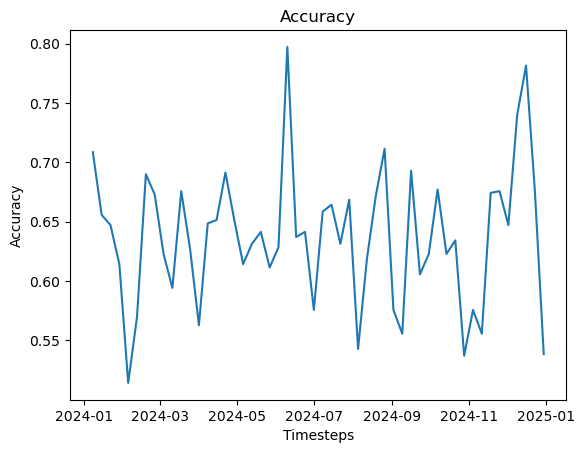

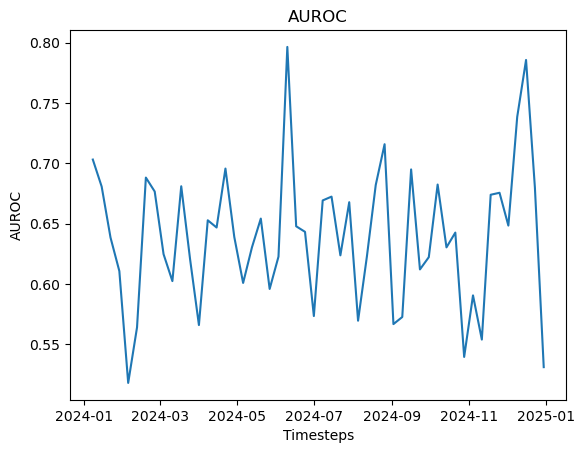

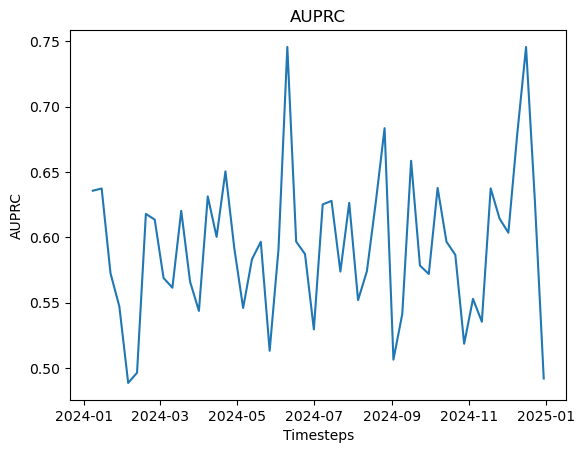

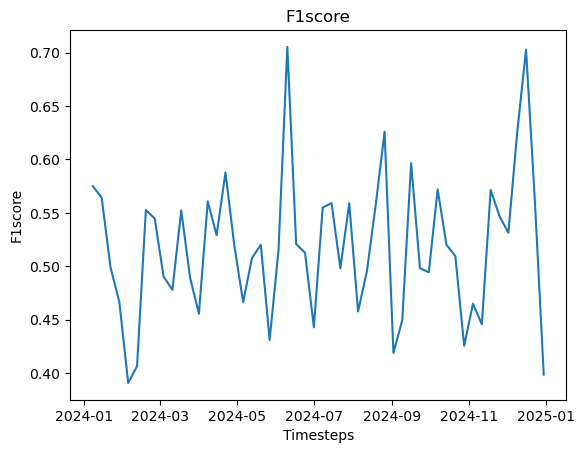

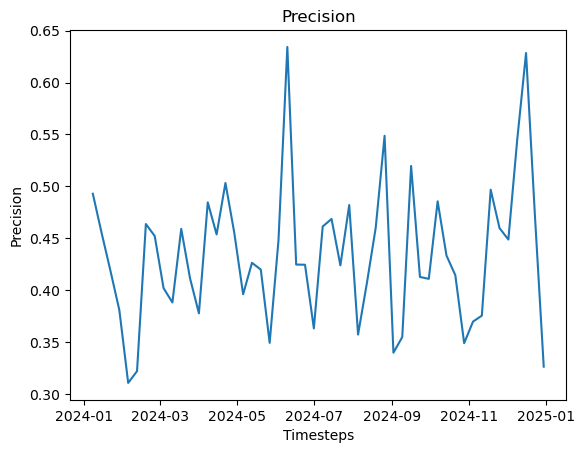

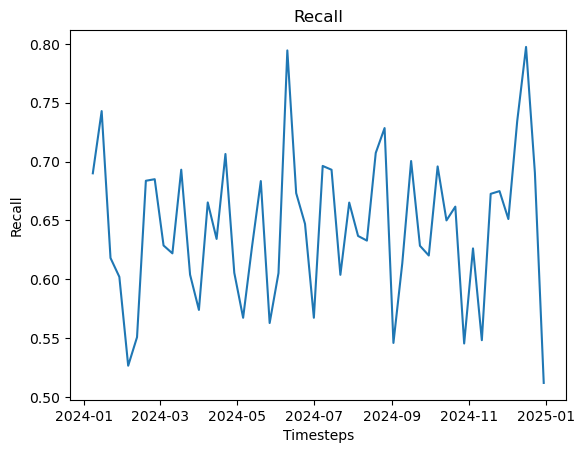

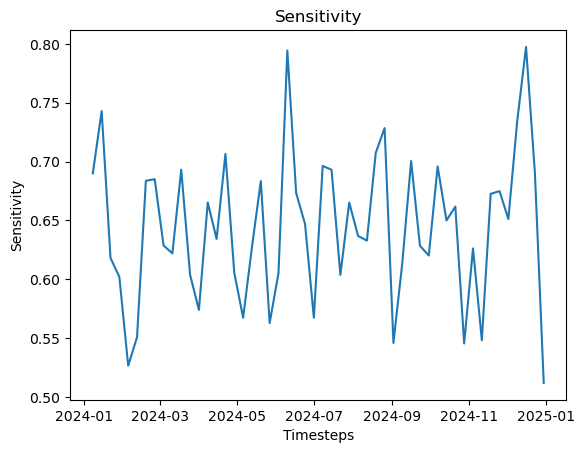

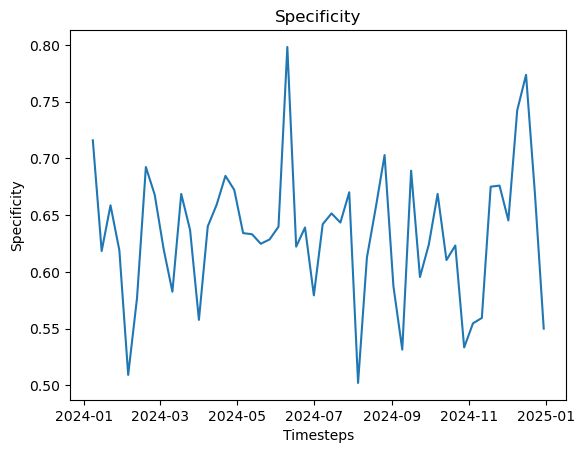

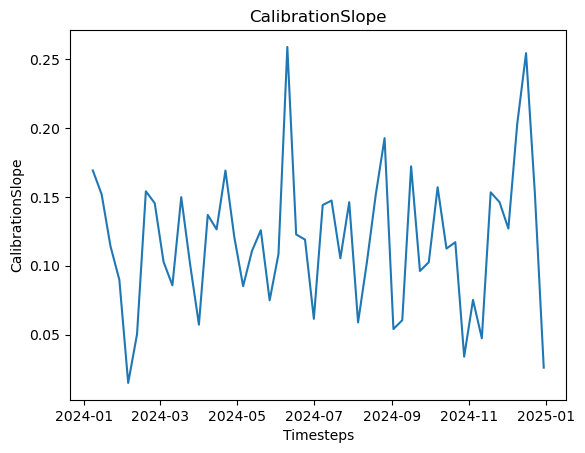

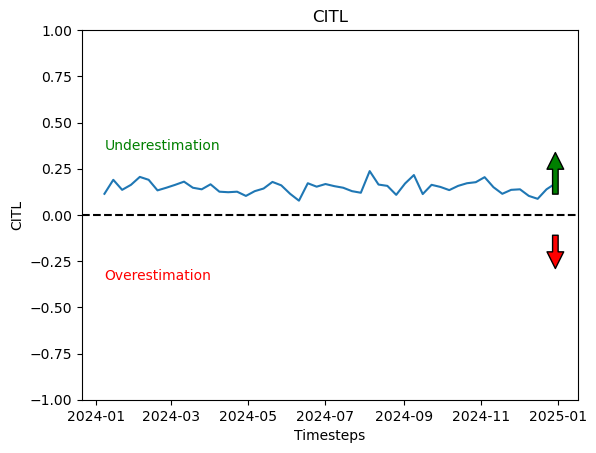

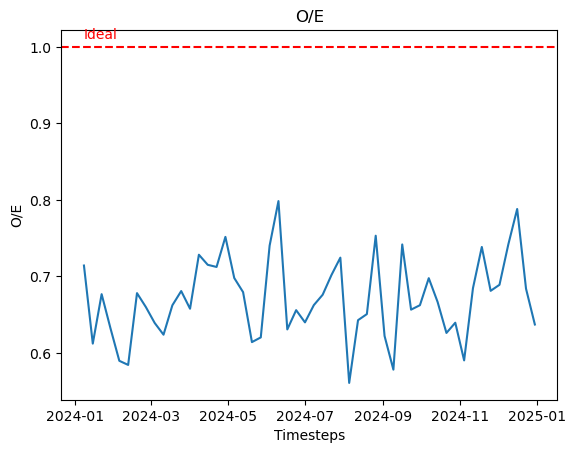

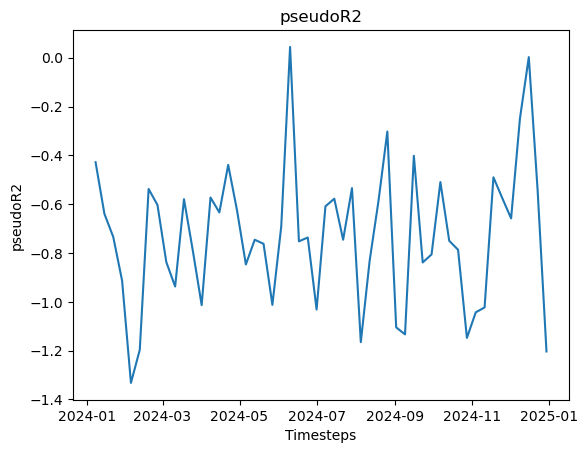

In [5]:
for key in log.keys():
    curlog = log[key]
    plt.figure()
    plt.plot(curlog.keys(), curlog.values())
    if key == 'CITL':
        plt.axhline(y=0, color='black', linestyle='--')
        plt.annotate('', xy=(max(curlog.keys()), 0.35), xytext=(max(curlog.keys()), 0.1),
                    arrowprops=dict(facecolor='green', shrink=0.05))
        plt.text(min(curlog.keys()), 0.35, 'Underestimation', fontsize=10, color='green')
        plt.annotate('', xy=(max(curlog.keys()), -0.3), xytext=(max(curlog.keys()), -0.1),
                    arrowprops=dict(facecolor='red', shrink=0.05))
        plt.text(min(curlog.keys()), -0.35, 'Overestimation', fontsize=10, color='red')
        plt.ylim(-1, 1)
    plt.title(key)
    plt.xlabel('Timesteps')
    plt.ylabel(key)
    